In [85]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

In [46]:
fire_data    = pd.read_csv("fire/data/fires_spain_since_2010.csv")
maps_data = pd.read_csv("tourism/data.csv")

maps_data.shape, fire_data.shape
df_tourism = maps_data.loc[maps_data['type'] == 'tourism']
num_tourism_entries = len(df_tourism)
df_tourism = df_tourism.reset_index(drop=True)

df_non_tourism = maps_data.loc[maps_data['type'] != 'tourism']
num_non_tourism_entries = len(df_non_tourism)
df_non_tourism = df_non_tourism.reset_index(drop=True)

#df_tourism.head()
#df_non_tourism.head()
num_tourism_entries, num_non_tourism_entries

(3707, 89879)

In [47]:
fire_data.sort_values("date", ascending=False).head()

,lat,lon,fire_val,date
49840,43.412500,-3.837287,8.0,2020-04-14
48398,41.712500,-7.976185,8.0,2020-04-12
48399,40.262500,-3.751188,8.0,2020-04-12
48400,40.262500,-3.740268,8.0,2020-04-12
48396,44.979167,-0.748083,8.0,2020-04-09


In [48]:
# bounding box of tourism data (fire data is "larger")
lat_min = maps_data.lat.min()
lat_max = maps_data.lat.max()
lon_min = maps_data.lon.min()
lon_max = maps_data.lon.max()
lat_min, lat_max, lon_min, lon_max

(41.7907476, 43.7903123, -9.2989921, -6.7159627)

In [57]:
# fire data is available for more regions => filter approx to tourism data
#fire_data = (fire_data
#    .query("lat.between(@lat_min, @lat_max)")
#    .query("lon.between(@lon_min, @lon_max)"))
fire_data =  fire_data.loc[fire_data['lat'] <= lat_max ] 
fire_data =  fire_data.loc[fire_data['lat'] >= lat_min ]
fire_data =  fire_data.loc[fire_data['lon'] <= lon_max ]
fire_data =  fire_data.loc[fire_data['lon'] >= lon_min]
fire_data = fire_data.reset_index(drop=True)

In [58]:
fire_data.sort_values("date", ascending=False).head()

,lat,lon,fire_val,date
7755,42.204167,-8.746698,8.0,2020-04-03
7756,42.204167,-8.735448,8.0,2020-04-03
7754,42.020833,-8.227874,8.0,2020-03-29
682,41.929167,-7.151932,8.0,2020-03-27
683,41.920833,-7.150998,8.0,2020-03-27


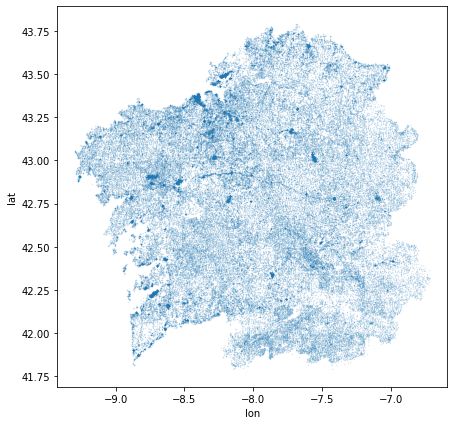

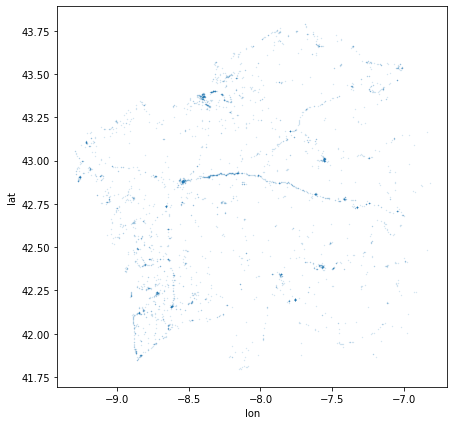

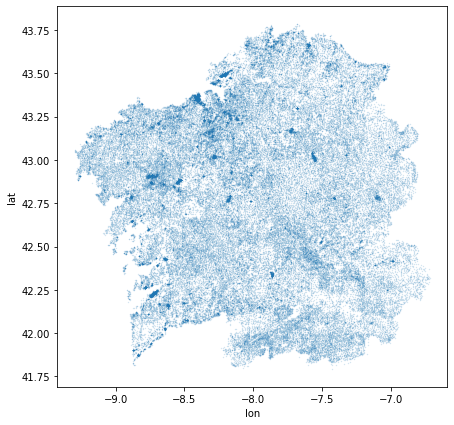

In [59]:
maps_data.plot.scatter(x="lon", y="lat", s=.1, alpha=.25, figsize=(7,7))
df_tourism.plot.scatter(x="lon", y="lat", s=.1, alpha=.25, figsize=(7,7))
df_non_tourism.plot.scatter(x="lon", y="lat", s=.1, alpha=.25, figsize=(7,7))

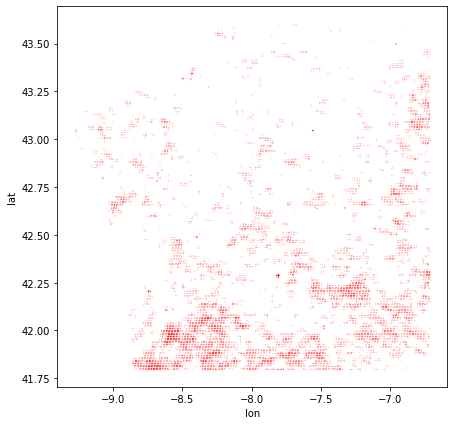

In [60]:
fire_data.plot.scatter(x="lon", y="lat", s=.1, alpha=.25, figsize=(7,7), c="r")

In [112]:
X_tourism = np.deg2rad(df_tourism[["lat","lon"]].to_numpy())
X_non_tourism = np.deg2rad(df_non_tourism[["lat","lon"]].to_numpy())
X_fire_rad    = np.deg2rad(fire_data[["lat","lon"]].to_numpy())

In [62]:
# probe grid
probe_grid_ticks_lat = np.linspace(lat_min, lat_max, num=20)
probe_grid_ticks_lon = np.linspace(lon_min, lon_max, num=20)
probe_grid_lats, probe_grid_lons = np.meshgrid(probe_grid_ticks_lat, probe_grid_ticks_lon)
probe_grid_lats = probe_grid_lats.flatten()
probe_grid_lons = probe_grid_lons.flatten()
X_probe = np.array([probe_grid_lats, probe_grid_lons]).T
X_probe.shape

(400, 2)

In [63]:
# Probe at fire locations
X_fire = np.array([[fire_data['lon'][i], fire_data['lat'][i]] for i in range(len(fire_data))])
X_fire.shape

(13228, 2)

In [114]:
kde_tourism = KernelDensity(bandwidth=.0005, metric="haversine", atol=0.1).fit(X_tourism)
kde_non_tourism  = KernelDensity(bandwidth=.0005, metric="haversine", atol=0.1).fit(X_non_tourism)

In [115]:
scores_tourism = (kde_tourism.score_samples(X_fire_rad))
scores_non_tourism = (kde_non_tourism.score_samples(X_fire_rad ))

In [116]:
np.set_printoptions(precision=10)
#log_diff = sum(scores_non_tourism) - sum(scores_tourism)
#diff = np.exp(np.prod(scores_non_tourism)/np.prod(scores_tourism))

log_diff = sum(scores_non_tourism) - sum(scores_tourism)
print(diff)

51068149.70057678


No handles with labels found to put in legend.


(3796.0, 13228)

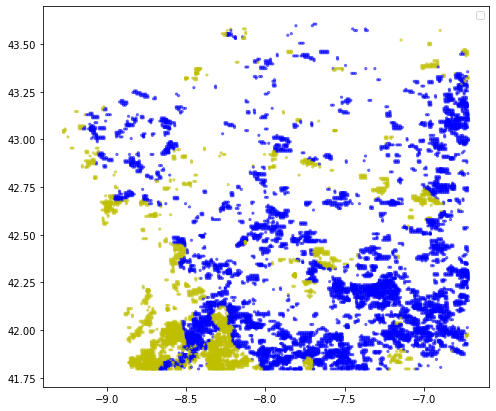

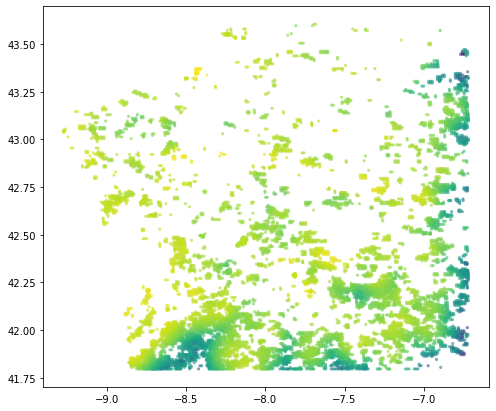

In [118]:
max_scores = np.ones(len(scores_tourism))
for i in range(len(scores_tourism)):
    if scores_tourism[i] > scores_non_tourism[i]:
        max_scores[i] = 1
    else:
        max_scores[i] = 0

colors = [['b','y'][int(max_scores[i])] for i in range(len(scores_tourism))]
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(X_fire[:,0], X_fire[:,1], zorder=1, alpha= 0.5, c= colors, s=5)
ax.legend()

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(X_fire[:,0], X_fire[:,1], zorder=1, alpha= 0.5, c= scores_tourism, s=5)
sum(max_scores), len(max_scores)